In [1]:
from glob import glob
from datetime import datetime, date
from os.path import join, basename, expanduser
import pickle
import numpy as np
import pandas as pd
import rioxarray as rxa
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from metloom.pointdata import SnotelPointData
from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)
lidar_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar'
fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare'

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_name(fp):
    name = basename(fp)
    if '_SD_' in name:
        return datetime.strptime(name.split('_')[-2], '%Y%m%d')
    elif '-snowdepth' in name:
        return datetime.strptime(name.split('_')[0], '%Y%m%d')

def get_snow_depth_change(name, date1, date2):
    snotels = {'mores':"637:ID:SNTL", 'dry_creek':"978:ID:SNTL", 'banner':"312:ID:SNTL"}
    snotel_point = SnotelPointData(snotels[name], name + '_snotel')
    df = snotel_point.get_daily_data(
        date1, date2,
        [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    if df['SNOWDEPTH_units'].iloc[0] == 'in':
        sd = df['SNOWDEPTH']*0.0254
        return sd.iloc[-1] - sd.iloc[0]
    else:
        print('Not in inches?')

def get_snotel_loc(name):
    snotels = {'mores':"637:ID:SNTL", 'dry_creek':"978:ID:SNTL", 'banner':"312:ID:SNTL"}
    snotel_point = SnotelPointData(snotels[name], name + '_snotel')
    df = snotel_point.get_daily_data(
        '2020-01-01', '2020-01-03',
        [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    return df.geometry.iloc[0]

def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

from math import cos, sin, asin, sqrt, radians
def calc_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [ ]:
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
            print(basename(loc_dir))
            print(sd_fp)
            sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
            lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
            imgs = [im for im in low_vv_imgs if (im['flight1'] < lidar_date) & (im['flight2'] > lidar_date)]
            save = True
            if len(imgs) == 1:
                img = imgs[0]
            elif len(imgs) > 1:
                img = imgs[1]
            elif len(imgs) == 0:
                td = pd.Timedelta('1 day')
                while len(imgs) == 0:
                    imgs = [im for im in low_vv_imgs if (im['flight1'] - td < lidar_date) & (im['flight2'] + td > lidar_date)]
                    td += pd.Timedelta('1 day')
                img = imgs[0]
            phase = rxa.open_rasterio(img['fp'])
            phase = phase.rio.clip_box(*sd.rio.bounds())
            inc = rxa.open_rasterio(img['inc'])
            inc = inc.rio.reproject_match(phase)
            cor = rxa.open_rasterio(img['cor'])
            cor = cor.rio.reproject_match(phase)
            sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
            loc = get_snotel_loc(basename(loc_dir))
            snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
            phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
            snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
            if np.isnan(snotel_phase):
                snotel_phase = 0
            uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
            phase.values = uavsar_sd

            sd = sd.rio.reproject_match(phase)
            sd = sd.where(sd < 10)
            sd = sd.where(sd > 0)
            # phase = phase.where(phase < )


            gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
            fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                    ['lower left', 'right']],
                    figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
            sd = sd.where(sd < 1000)
            sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
            axes['upper left'].set_title('Lidar Snow Depth')
            phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
            axes['lower left'].set_title('Uavsar Snow Depth Change')
            for ax in ['upper left', 'lower left']:
                axes[ax].set_xlabel('')
                axes[ax].set_ylabel('')


            sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
            cond = (cors > 0.6)
            slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
            axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
            axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
            axes['right'].set_xlabel('Lidar Snow Depth')
            axes['right'].set_ylabel('Uavsar Snow Depth Change')
            name = '_'.join(basename(sd_fp).split('.')[:-1])
            fig.suptitle(f'Comparison between Lidar and Uavsar for {name}')
            if save:
                plt.savefig(join(fig_dir, basename(sd_fp)))
            plt.show()
            

In [ ]:
from rasterio.enums import Resampling

low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        # if sd_fp == '/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/banner/SNEX20_QSI_SD_0.5M_USIDBS_20200218_20200219.tif':
            print(basename(loc_dir))
            print(sd_fp)
            sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
            lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
            imgs = [im for im in low_vv_imgs if (im['flight1'] < lidar_date) & (im['flight2'] > lidar_date)]
            if len(imgs) == 1:
                img = imgs[0]
            elif len(imgs) > 1:
                img = imgs[1]
                save = True
            elif len(imgs) == 0:
                td = pd.Timedelta('1 day')
                while len(imgs) == 0:
                    imgs = [im for im in low_vv_imgs if (im['flight1'] - td < lidar_date) & (im['flight2'] + td > lidar_date)]
                    td += pd.Timedelta('1 day')
                img = imgs[0]
            phase = rxa.open_rasterio(img['fp'])
            phase = phase.rio.clip_box(*sd.rio.bounds())

            desc = pd.read_csv(img['ann'])
                # calculate how to get to 30 metere resolution from 0.0005 degrees
            new_res_m = 30
            y1 = float(desc['grd.row_addr'][0])
            dy = float(desc['grd.row_mult'][0])
            x1 = float(desc['grd.col_addr'][0])
            dx = float(desc['grd.col_mult'][0])
            conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
            phase = phase.rio.reproject(phase.rio.crs, \
                                            shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                            resampling = Resampling.average)

            inc = rxa.open_rasterio(img['inc'])
            inc = inc.rio.reproject_match(phase)
            cor = rxa.open_rasterio(img['cor'])
            cor = cor.rio.reproject_match(phase)
            sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
            loc = get_snotel_loc(basename(loc_dir))
            snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
            phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
            snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
            if np.isnan(snotel_phase):
                snotel_phase = 0
            uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
            phase.values = uavsar_sd

            sd = sd.rio.reproject_match(phase)
            sd = sd.where(sd < 10)
            sd = sd.where(sd > 0)

            gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
            fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                    ['lower left', 'right']],
                    figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
            sd = sd.where(sd < 1000)
            sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
            axes['upper left'].set_title('Lidar Snow Depth')
            phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
            axes['lower left'].set_title('Uavsar Snow Depth Change')
            for ax in ['upper left', 'lower left']:
                axes[ax].set_xlabel('')
                axes[ax].set_ylabel('')


            sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
            cond = (cors > 0.6)
            slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
            axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
            axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
            axes['right'].set_xlabel('Lidar Snow Depth')
            axes['right'].set_ylabel('Uavsar Snow Depth Change')
            name = '_'.join(basename(sd_fp).split('.')[:-1])
            fig.suptitle(f'Comparison between Lidar and Uavsar for {name}')
            plt.savefig(join(fig_dir, 're30m_'+basename(sd_fp)))
            plt.show()
            

In [9]:
from rasterio.enums import Resampling

fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare/all'
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        for img in low_vv_imgs:
            try:
                print(basename(loc_dir))
                print(sd_fp)
                sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
                lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
                save = True
                phase = rxa.open_rasterio(img['fp'])
                phase = phase.rio.clip_box(*sd.rio.bounds())

                desc = pd.read_csv(img['ann'])
                    # calculate how to get to 30 metere resolution from 0.0005 degrees
                new_res_m = 30
                y1 = float(desc['grd.row_addr'][0])
                dy = float(desc['grd.row_mult'][0])
                x1 = float(desc['grd.col_addr'][0])
                dx = float(desc['grd.col_mult'][0])
                conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
                phase = phase.rio.reproject(phase.rio.crs, \
                                                shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                                resampling = Resampling.average)

                inc = rxa.open_rasterio(img['inc'])
                inc = inc.rio.reproject_match(phase)
                cor = rxa.open_rasterio(img['cor'])
                cor = cor.rio.reproject_match(phase)
                sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
                print(f'Snow depth change: {sd_delta}m')
                loc = get_snotel_loc(basename(loc_dir))
                snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
                phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
                snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
                if np.isnan(snotel_phase):
                    snotel_phase = 0
                uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
                phase.values = uavsar_sd
                iqr = np.subtract(*np.nanpercentile(uavsar_sd, [75, 25]))

                print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
                print(f'Snow Depth change IQR: {iqr}')

                sd = sd.rio.reproject_match(phase)
                sd = sd.where(sd < 10)
                sd = sd.where(sd > 0)

                print(f'Lidar Snow depth mean {np.nanmean(sd)}')
                iqr = np.subtract(*np.nanpercentile(sd, [75, 25]))
                print(f'Lidar Snow depth IQR {iqr}')

                gs_kw = dict(width_ratios=[1, 1.3], height_ratios=[1, 1])
                fig, axes = plt.subplot_mosaic([['upper left', 'right'],
                        ['lower left', 'right']],
                        figsize=(12, 8), layout="constrained", gridspec_kw=gs_kw)
                sd = sd.where(sd < 1000)
                sd.where(~np.isnan(phase)).plot(ax = axes['upper left'])
                axes['upper left'].set_title('Lidar Snow Depth')
                phase.where(~np.isnan(sd)).plot(ax = axes['lower left'])
                axes['lower left'].set_title('Uavsar Snow Depth Change')
                for ax in ['upper left', 'lower left']:
                    axes[ax].set_xlabel('')
                    axes[ax].set_ylabel('')


                sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
                cond = (cors > 0.5)
                slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])
                axes['right'].hist2d(sds[cond], uav[cond], bins = 50)
                axes['right'].annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [0.64,0.97], xycoords = 'axes fraction')
                axes['right'].set_xlabel('Lidar Snow Depth')
                axes['right'].set_ylabel('Uavsar Snow Depth Change')
                name = '_'.join(basename(sd_fp).split('.')[:-1])
                f1 = img['flight1'].date().strftime("%Y-%m-%d")
                f2 = img['flight2'].date().strftime("%Y-%m-%d")
                fig.suptitle(f'Comparison between Lidar - {name} and Uavsar - {f1}_{f2}')
                if r>0.5:
                    fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare'
                    plt.savefig(join(fig_dir, basename(loc_dir)+'_re30m_'+name+'UV'+f1+'_'+f2+'.tif'))
                    fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare/all'
                    plt.savefig(join(fig_dir, basename(loc_dir)+'_re30m_'+name+'UV'+f1+'_'+f2+'.tif'))
                    plt.show()
                else:
                    fig_dir = '/bsuhome/zacharykeskinen/uavsar/figures/lidar_sd_compare/all'
                    plt.savefig(join(fig_dir, basename(loc_dir)+'_re30m_'+name+'UV'+f1+'_'+f2+'.tif'))
                    plt.close()
            except ValueError as e:
                print('Error!')
                print(e)
                f1 = img['flight1'].date().strftime("%Y-%m-%d")
                f2 = img['flight2'].date().strftime("%Y-%m-%d")
                print(f'Uavsar - {f1}_{f2}')


mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.13706105947494507
Snow Depth change IQR: 0.08634189702570438


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.02897686186804471. intercept: -0.18669857791503813. r_value 0.10914773241698797. p value: 5.681599864905123e-39
mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif
Snow depth change: 0.5333999999999999m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.48184993863105774
Snow Depth change IQR: 0.14861156791448593


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.06638365890246774. intercept: 0.39778451238200185. r_value 0.2391465536173309. p value: 1.0125296301846073e-225
mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11371016502380371
Snow Depth change IQR: 0.048502903431653976


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.030377157702099693. intercept: -0.16443917061221636. r_value 0.29941837161006846. p value: 0.0
mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14317084848880768
Snow Depth change IQR: 0.05984546057879925


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.050033931968171894. intercept: -0.22813559738973055. r_value 0.47729804395289877. p value: 0.0
mores
/bsuhome/zacharykeskinen/scratch/data/uavsar/lidar/Lowman,_CO/mores/SNEX20_QSI_SD_0.5M_USIDMC_20200209_20200209.tif


KeyboardInterrupt: 

In [22]:
from rasterio.enums import Resampling

res = pd.DataFrame()
i = 0
low_vv_imgs = [fps for fps in image_fps if (fps['location'] == 'Lowman, CO') & (fps['pol'] == 'VV')]
for loc_dir in glob(join(lidar_dir , 'Lowman,_CO', '*')):
    sd_fps = glob(join(loc_dir, '*_SD_*')) + glob(join(loc_dir, '*snowdepth*'))
    for sd_fp in sd_fps:
        for img in low_vv_imgs:
            try:
                sd = rxa.open_rasterio(sd_fp).rio.reproject('EPSG:4326')
                lidar_date = pd.Timestamp(get_name(sd_fp).date()).tz_localize('US/MOUNTAIN')
                save = True
                phase = rxa.open_rasterio(img['fp'])
                phase = phase.rio.clip_box(*sd.rio.bounds())

                desc = pd.read_csv(img['ann'])
                    # calculate how to get to 30 metere resolution from 0.0005 degrees
                new_res_m = 30
                y1 = float(desc['grd.row_addr'][0])
                dy = float(desc['grd.row_mult'][0])
                x1 = float(desc['grd.col_addr'][0])
                dx = float(desc['grd.col_mult'][0])
                conversion = (new_res_m/1000) / calc_distance(y1, x1, y1+dy, x1 + dx)
                phase = phase.rio.reproject(phase.rio.crs, \
                                                shape = (int(phase.rio.height/conversion), int(phase.rio.width/conversion)),
                                                resampling = Resampling.average)

                inc = rxa.open_rasterio(img['inc'])
                inc = inc.rio.reproject_match(phase)
                cor = rxa.open_rasterio(img['cor'])
                cor = cor.rio.reproject_match(phase)
                sd_delta = get_snow_depth_change(basename(loc_dir),img['flight1'],img['flight2'])
                print(f'Snow depth change: {sd_delta}m')
                loc = get_snotel_loc(basename(loc_dir))
                snotel_inc = inc.sel(x = loc.x, y = loc.y, method = 'nearest').values[0]
                phase_correct = phase_from_depth(sd_delta, inc_angle= snotel_inc, density = 250)
                snotel_phase = phase.sel(x= loc.x, y=loc.y, method = 'nearest').values[0]
                if np.isnan(snotel_phase):
                    snotel_phase = 0
                uavsar_sd = depth_from_phase(phase.values - (snotel_phase - phase_correct), inc.values, density = 250)
                phase.values = uavsar_sd

                print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
                print(f'Snow Depth change IQR: {iqr}')

                sd = sd.rio.reproject_match(phase)
                sd = sd.where(sd < 10)
                sd = sd.where(sd > 0)

                print(f'Lidar Snow depth mean {np.nanmean(sd)}')
                iqr = np.subtract(*np.nanpercentile(sd, [75, 25]))
                print(f'Lidar Snow depth IQR {iqr}')

                sd = sd.where(sd < 1000)
                sd = sd.where(~np.isnan(phase))
                phase = phase.where(~np.isnan(sd))

                sds, uav, cors = clean_nps([sd.values.ravel(), phase.values.ravel(), cor.values.ravel()])
                cond = (cors > 0.35)
                slope, intercept,r,p, _, _ = r2_value(sds[cond], uav[cond])

                name = '_'.join(basename(sd_fp).split('.')[:-1])
                f1 = img['flight1'].date().strftime("%Y-%m-%d")
                f2 = img['flight2'].date().strftime("%Y-%m-%d")

                res.loc[i, 'flight1'] = f1
                res.loc[i, 'flight2'] = f2
                res.loc[i, 'r'] = r
                res.loc[i, 'uavsar_sd_mean'] = np.nanmean(uavsar_sd)
                iqr = np.subtract(*np.nanpercentile(uavsar_sd, [75, 25]))
                res.loc[i, 'uavsar_sd_iqr'] = iqr
                res.loc[i, 'lidar_sd_mean'] = np.nanmean(sd)
                iqr = np.subtract(*np.nanpercentile(uavsar_sd, [75, 25]))
                res.loc[i, 'lidar_sd_iqr'] = iqr
                res.loc[i, 'snotel_sd_change'] = sd_delta
                i += 1
            except:
                pass


Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.13706105947494507
Snow Depth change IQR: 0.556640625


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.03020341406595763. intercept: -0.1924927434258033. r_value 0.11845552902453721. p value: 1.1116366420814444e-91
Snow depth change: 0.5333999999999999m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.48184993863105774
Snow Depth change IQR: 0.08634189702570438


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.052073126334576045. intercept: 0.4202955835904696. r_value 0.19050583081239336. p value: 5.646608661577512e-253
Snow depth change: -0.127m
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14317084848880768
Snow Depth change IQR: 0.14861156791448593


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.04905762583779816. intercept: -0.225744389078798. r_value 0.4767035966330743. p value: 0.0
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11121053993701935
Snow Depth change IQR: 0.05984546057879925


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: -0.0006214668208568007. intercept: -0.11175765109184974. r_value -0.006788239698160871. p value: 0.20765407855162055
Snow depth change: -0.17779999999999996m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.20019075274467468
Snow Depth change IQR: 0.050706516951322556


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.03136470201436472. intercept: -0.25402703350895417. r_value 0.24851421032173043. p value: 0.0
Snow depth change: 0.381m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.08191154152154922


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11244872957468033
Snow Depth change IQR: 0.556640625


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: -0.01906014861714105. intercept: -0.08141771012128093. r_value -0.17266463461610296. p value: 1.488190143691022e-306
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10303185135126114
Snow Depth change IQR: 0.06953860633075237


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: -0.04392516960157759. intercept: -0.011013785679279395. r_value -0.22755022956739238. p value: 0.0
Snow depth change: 0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.08878441900014877
Snow Depth change IQR: 0.05155504494905472


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.018956501296997153. intercept: 0.06043667599659491. r_value 0.12639767064796853. p value: 3.943577251619977e-99
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10837697982788086
Snow Depth change IQR: 0.0728263184428215


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: -0.0076249792032803305. intercept: -0.0945209684723047. r_value -0.07923719788848327. p value: 2.4003948985130914e-60
Snow depth change: -0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.2953369617462158
Snow Depth change IQR: 0.05574673414230347


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: -0.003640299721965341. intercept: -0.29230912644176904. r_value -0.020278619043507418. p value: 0.0008213837636881513
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14063724875450134
Snow Depth change IQR: 0.10512054711580276


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.7972980737686157
Lidar Snow depth IQR 0.556640625
slope: 0.008531313213321252. intercept: -0.1592024952773323. r_value 0.08929829297371542. p value: 3.1336590025127394e-108
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.13706105947494507
Snow Depth change IQR: 0.048832520842552185


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: 0.09577120373569271. intercept: -0.30531624760971965. r_value 0.4330736516871725. p value: 0.0
Snow depth change: 0.5333999999999999m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.48184993863105774
Snow Depth change IQR: 0.08634189702570438


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.010963713584453642. intercept: 0.5238198944290643. r_value -0.04998714937740411. p value: 1.155593280527906e-18
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11371016502380371
Snow Depth change IQR: 0.14861156791448593


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: 0.014585704300220671. intercept: -0.13144082859365716. r_value 0.18122797194495302. p value: 1.0590467365904615e-276
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14317084848880768
Snow Depth change IQR: 0.048502903431653976


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: 0.04445757133517584. intercept: -0.20849276029153446. r_value 0.5470972497435471. p value: 0.0
Snow depth change: -0.17779999999999996m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.18328113853931427
Snow Depth change IQR: 0.05984546057879925


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.030194365836699717. intercept: -0.1370856441141861. r_value -0.3116485055213179. p value: 0.0
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11121053993701935
Snow Depth change IQR: 0.07616204023361206


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.004310467090271445. intercept: -0.10554317616763806. r_value -0.05876539927661438. p value: 1.0732506525873712e-27
Snow depth change: -0.17779999999999996m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.20019075274467468
Snow Depth change IQR: 0.050706516951322556


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: 0.05053235487015502. intercept: -0.27995372500711724. r_value 0.49120847076765906. p value: 0.0
Snow depth change: 0.381m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.08191154152154922


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11244872957468033
Snow Depth change IQR: 0.739013671875


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.03739328388042871. intercept: -0.053290187819321905. r_value -0.4233317117183179. p value: 0.0
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10303185135126114
Snow Depth change IQR: 0.06953860633075237


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.053171057832280495. intercept: -0.0015325093866692119. r_value -0.3521086270992619. p value: 0.0
Snow depth change: 0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.08878441900014877
Snow Depth change IQR: 0.05155504494905472


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: 0.04125481142166811. intercept: 0.023862390844648154. r_value 0.3389264560182218. p value: 0.0
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10837697982788086
Snow Depth change IQR: 0.0728263184428215


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.017213514706354738. intercept: -0.0791510406399952. r_value -0.2221078415171961. p value: 0.0
Snow depth change: -0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.2953369617462158
Snow Depth change IQR: 0.05574673414230347


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: -0.0366505889539354. intercept: -0.23272918580510954. r_value -0.243129110157231. p value: 0.0
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14063724875450134
Snow Depth change IQR: 0.10512054711580276


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.609180212020874
Lidar Snow depth IQR 0.739013671875
slope: 0.01909371638868017. intercept: -0.17500828923589976. r_value 0.24438523397443324. p value: 0.0
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.13706105947494507
Snow Depth change IQR: 0.048832520842552185


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.05841490559239554. intercept: -0.24218628263200406. r_value 0.2811103998862821. p value: 4.339536976780757e-132
Snow depth change: 0.5333999999999999m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.48184993863105774
Snow Depth change IQR: 0.08634189702570438


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.08122634760892292. intercept: 0.43836323360662577. r_value 0.375344267299797. p value: 9.273453431923414e-201
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11371016502380371
Snow Depth change IQR: 0.14861156791448593


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.025779890122355688. intercept: -0.153145135297038. r_value 0.2692904570409384. p value: 2.391802970355444e-187
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14317084848880768
Snow Depth change IQR: 0.048502903431653976


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.05053244802197289. intercept: -0.23277800115494224. r_value 0.5693681664618088. p value: 0.0
Snow depth change: -0.17779999999999996m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.18328113853931427
Snow Depth change IQR: 0.05984546057879925


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: -0.023474830571403527. intercept: -0.14347142062806226. r_value -0.20656343534228366. p value: 1.8139450337846512e-104
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11121053993701935
Snow Depth change IQR: 0.07616204023361206


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: -0.005863129105535388. intercept: -0.0986874860164821. r_value -0.06659266074350836. p value: 3.120380998469847e-10
Snow depth change: -0.17779999999999996m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.20019075274467468
Snow Depth change IQR: 0.050706516951322556


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.03754573498782978. intercept: -0.2680086573329394. r_value 0.3786989380224102. p value: 0.0
Snow depth change: 0.381m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.08191154152154922


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.11244872957468033
Snow Depth change IQR: 0.636474609375


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: -0.021072234604844454. intercept: -0.06723113677656942. r_value -0.2619857280460882. p value: 3.2139677807570218e-195
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10303185135126114
Snow Depth change IQR: 0.06953860633075237


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: -0.042852322011062406. intercept: -0.019910388989500177. r_value -0.31004027027499564. p value: 7.779117758457625e-285
Snow depth change: 0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.08878441900014877
Snow Depth change IQR: 0.05155504494905472


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.013106451139642827. intercept: 0.05262090545653919. r_value 0.10079801101283586. p value: 4.460967628663629e-20
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10837697982788086
Snow Depth change IQR: 0.0728263184428215


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: -0.014451878032382973. intercept: -0.07250292254290072. r_value -0.18122439280353386. p value: 1.7423196964973908e-88
Snow depth change: -0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.2953369617462158
Snow Depth change IQR: 0.05574673414230347


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: -0.0026321390439440384. intercept: -0.27755237710856573. r_value -0.016775801603749134. p value: 0.15214334504047236
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.14063724875450134
Snow Depth change IQR: 0.10512054711580276


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.8291430473327637
Lidar Snow depth IQR 0.636474609375
slope: 0.00694032211546151. intercept: -0.1610701014618402. r_value 0.07548214598645665. p value: 3.926588545991542e-22
Snow depth change: -0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.13520187139511108
Snow Depth change IQR: 0.048832520842552185


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: -0.010187471900941826. intercept: -0.14563640388379406. r_value -0.07006957098859987. p value: 9.046305089908637e-24
Snow depth change: 0.508m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.7063353657722473
Snow Depth change IQR: 0.0683073177933693


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.07053769662806328. intercept: 0.6679059154158423. r_value 0.17409840355627063. p value: 7.37724305114078e-167
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.09367820620536804
Snow Depth change IQR: 0.3363393247127533


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.045767936100452475. intercept: -0.11912912572260773. r_value 0.4658673097692846. p value: 0.0
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10433637350797653
Snow Depth change IQR: 0.0738038718700409


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.037975969936543535. intercept: -0.1300770508599179. r_value 0.49715104575407815. p value: 0.0
Snow depth change: -0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.13561998307704926
Snow Depth change IQR: 0.06126498803496361


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.0016206362986260073. intercept: -0.13373814578633897. r_value 0.019181108772314187. p value: 3.866476005432914e-06
Snow depth change: -0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.0827179029583931
Snow Depth change IQR: 0.062138110399246216


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.006786301379325088. intercept: -0.09397986783227387. r_value 0.06525811448689763. p value: 1.3148079960012375e-42
Snow depth change: -0.1524000000000001m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.21040870249271393
Snow Depth change IQR: 0.05757858511060476


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: -0.005865581143601224. intercept: -0.20828201718297368. r_value -0.04048380087618316. p value: 2.9840763235399506e-22
Snow depth change: 0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.11005692929029465


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.09106055647134781
Snow Depth change IQR: 0.673980712890625


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: -0.0010345236423670108. intercept: -0.0902320347885326. r_value -0.012534824648544865. p value: 0.0011680783014280617
Snow depth change: -0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.07030484080314636
Snow Depth change IQR: 0.05432019755244255


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.00977154458913971. intercept: -0.08104141182271649. r_value 0.16518010455226786. p value: 0.0
Snow depth change: 0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.09864376485347748
Snow Depth change IQR: 0.03813013434410095


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.06499978956702912. intercept: 0.049066900441245204. r_value 0.49642319227772136. p value: 0.0
Snow depth change: 0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.0352737233042717
Snow Depth change IQR: 0.06684927456080914


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.026543835256336176. intercept: 0.015502514821705223. r_value 0.31945136735110735. p value: 0.0
Snow depth change: -0.15239999999999987m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.053574882447719574


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
Snow depth change: -0.10159999999999991m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.1394842118024826
Snow Depth change IQR: 0.673980712890625


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.0542833805084229
Lidar Snow depth IQR 0.673980712890625
slope: 0.02247752918920662. intercept: -0.16254890512734027. r_value 0.16957816928263877. p value: 0.0
Snow depth change: 0.025399999999999867m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.07909424602985382


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
Snow depth change: 0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.588134765625


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.08890761435031891
Snow Depth change IQR: 0.588134765625


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.023002204272321275. intercept: -0.1240407624108715. r_value 0.29961768747512374. p value: 0.0
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10232782363891602
Snow Depth change IQR: 0.04217706620693207


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.03972134915895181. intercept: -0.16101686860252992. r_value 0.47545129578520623. p value: 0.0
Snow depth change: -0.07619999999999982m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.07147350907325745
Snow Depth change IQR: 0.04429049789905548


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.019173274585629493. intercept: -0.09990944857646626. r_value 0.30626369219159677. p value: 0.0
Snow depth change: 0.025399999999999867m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.036846552044153214


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
Snow depth change: -0.07619999999999982m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.12263953685760498
Snow Depth change IQR: 0.588134765625


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.011534247863256714. intercept: -0.13866267850709785. r_value 0.12035405943091322. p value: 0.0
Snow depth change: 0.381m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.32197079062461853
Snow Depth change IQR: 0.06140170991420746


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.052495063342910674. intercept: 0.255054669814206. r_value 0.24534989502757437. p value: 0.0
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.1111055389046669
Snow Depth change IQR: 0.13450982421636581


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: -0.02422390517623959. intercept: -0.08645165022726234. r_value -0.2701567569507953. p value: 0.0
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.07392358034849167
Snow Depth change IQR: 0.05873696692287922


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: -0.0003370180977104052. intercept: -0.07545555836324898. r_value -0.006403231908338547. p value: 0.00032181239128975655
Snow depth change: 0.0m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.0006132690468803048
Snow Depth change IQR: 0.036450738087296486


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.023245147934522422. intercept: -0.028406206966903706. r_value 0.21053081040404617. p value: 0.0
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.06897004693746567
Snow Depth change IQR: 0.05477242637425661


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: -0.007562785872953571. intercept: -0.06140149318100119. r_value -0.14665705070318186. p value: 0.0
Snow depth change: -0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.08522888273000717
Snow Depth change IQR: 0.03338336758315563


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.027443196337516965. intercept: -0.12348226137414917. r_value 0.2953970309553282. p value: 0.0
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.1321476846933365
Snow Depth change IQR: 0.051965516060590744


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.5124353170394897
Lidar Snow depth IQR 0.588134765625
slope: 0.007888651513925968. intercept: -0.1435401510345613. r_value 0.0981985439178845. p value: 0.0
Snow depth change: 0.025399999999999867m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.050411080941557884


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
Snow depth change: 0.254m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.58251953125


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.08890761435031891
Snow Depth change IQR: 0.58251953125


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.021519872585587192. intercept: -0.12161156756289725. r_value 0.28628692336800593. p value: 0.0
Snow depth change: -0.10160000000000013m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.10232782363891602
Snow Depth change IQR: 0.04217706620693207


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.044063745126255244. intercept: -0.16548088473954525. r_value 0.5675364655462974. p value: 0.0
Snow depth change: -0.07619999999999982m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.07147350907325745
Snow Depth change IQR: 0.04429049789905548


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.018757180609645072. intercept: -0.09929595671331753. r_value 0.3049343606187722. p value: 0.0
Snow depth change: 0.025399999999999867m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean nan
Snow Depth change IQR: 0.036846552044153214


/tmp/ipykernel_30445/2940413115.py:44: RuntimeWarning: Mean of empty slice
  print(f'Snow depth change mean {np.nanmean(uavsar_sd)}')
/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
Snow depth change: -0.07619999999999982m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.12263953685760498
Snow Depth change IQR: 0.58251953125


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.02636941420809784. intercept: -0.16028205225719255. r_value 0.2852461887711383. p value: 0.0
Snow depth change: 0.381m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean 0.32197079062461853
Snow Depth change IQR: 0.06140170991420746


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.07069793391988373. intercept: 0.22811042953442529. r_value 0.3374721761659794. p value: 0.0
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.1111055389046669
Snow Depth change IQR: 0.13450982421636581


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: -0.029461627387226866. intercept: -0.07851926261064059. r_value -0.3373570221737249. p value: 0.0
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.07392358034849167
Snow Depth change IQR: 0.05873696692287922


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: -0.0005150311541020507. intercept: -0.07521422974667662. r_value -0.010066563586824097. p value: 1.6114281009289875e-08
Snow depth change: 0.0m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.0006132690468803048
Snow Depth change IQR: 0.036450738087296486


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.02752491791392621. intercept: -0.0347409016227339. r_value 0.25717315523238315. p value: 0.0
Snow depth change: -0.050799999999999956m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.06897004693746567
Snow Depth change IQR: 0.05477242637425661


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: -0.009551536507922544. intercept: -0.05845673724769627. r_value -0.1893744003474856. p value: 0.0
Snow depth change: -0.07620000000000005m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.08522888273000717
Snow Depth change IQR: 0.03338336758315563


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.02590795992727606. intercept: -0.1212140699068737. r_value 0.28486320710841695. p value: 0.0
Snow depth change: -0.127m
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
Snow depth change mean -0.1321476846933365
Snow Depth change IQR: 0.051965516060590744


/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/rioxarray/raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Lidar Snow depth mean 1.4838752746582031
Lidar Snow depth IQR 0.58251953125
slope: 0.00990473760895637. intercept: -0.1462439866568819. r_value 0.1288576319127769. p value: 0.0


In [ ]:
# res = pd.read_csv('/bsuhome/zacharykeskinen/uavsar/results/sd_compare_r.csv')

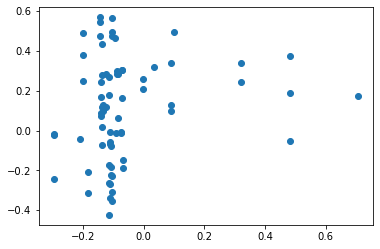

In [36]:
plt.scatter(res.uavsar_sd_mean, res.r)